In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from load import load_dataset
from model import CNN

Загрузка датасета

In [14]:
train_dir_path = "bird_dataset/train/"
test_dir_path = "bird_dataset/test/"
image_size = 160

train = load_dataset(train_dir_path, image_size)
test = load_dataset(test_dir_path, image_size)
print(train)

Dataset ImageFolder
    Number of datapoints: 1331
    Root location: bird_dataset/train/
    StandardTransform
Transform: Compose(
               Resize(size=(160, 160), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [4]:
bs = 32
train_loader = torch.utils.data.DataLoader(train, batch_size=bs)
test_loader = torch.utils.data.DataLoader(test, batch_size=bs)

Подсчёт размера для слоя fc1

In [5]:
160 / 4 / 4

10.0

In [7]:
model = CNN()

model.fc2.bias.data.fill_(0)
model.fc2.weight.data *= 0.001

Подсчёт ошибки на первой эпохе (при случайном выборе класса)

In [8]:
-torch.tensor(1/7).log()

tensor(1.9459)

Обучение

In [9]:
num_epochs = 40
learning_rate = 0.001

x = [epoch for epoch in range(0, num_epochs)]
y = []

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_f = torch.nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_f(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss = running_loss / len(train_loader)
    y.append(loss)
    print(f'epoch: {epoch+1}/{num_epochs}, loss: {loss}')


epoch: 1/40, loss: 2.7269421569293453
epoch: 2/40, loss: 2.0369207631973993
epoch: 3/40, loss: 2.0714213252067566
epoch: 4/40, loss: 2.0059149066607156
epoch: 5/40, loss: 2.0235752434957597
epoch: 6/40, loss: 1.9788837149029685
epoch: 7/40, loss: 2.0050003698893955
epoch: 8/40, loss: 2.036944043068659
epoch: 9/40, loss: 1.9534208604267664
epoch: 10/40, loss: 1.9088831799370902
epoch: 11/40, loss: 1.8542169729868572
epoch: 12/40, loss: 1.8094835423287892
epoch: 13/40, loss: 1.730380926813398
epoch: 14/40, loss: 1.6767499049504597
epoch: 15/40, loss: 1.5678810079892476
epoch: 16/40, loss: 1.5163802930286951
epoch: 17/40, loss: 1.4694887754463015
epoch: 18/40, loss: 1.408280338559832
epoch: 19/40, loss: 1.2712504473470507
epoch: 20/40, loss: 1.1777622536534356
epoch: 21/40, loss: 1.1566597421964009
epoch: 22/40, loss: 1.1084970001663481
epoch: 23/40, loss: 1.0243890760909944
epoch: 24/40, loss: 0.9300509863311336
epoch: 25/40, loss: 0.8742887711241132
epoch: 26/40, loss: 0.811868425636064

Без исправления ошибки на 1 эпохе

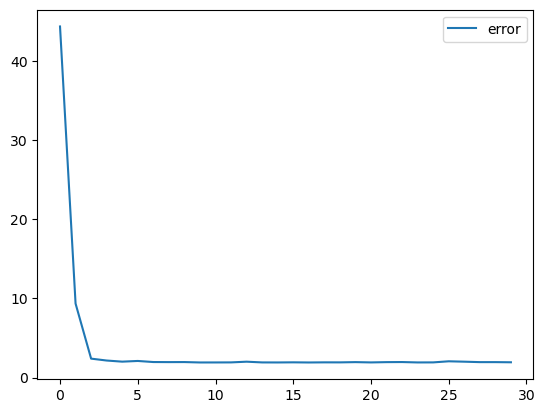

In [17]:
plt.plot(x, y, label='error')
plt.legend()
plt.show()

После

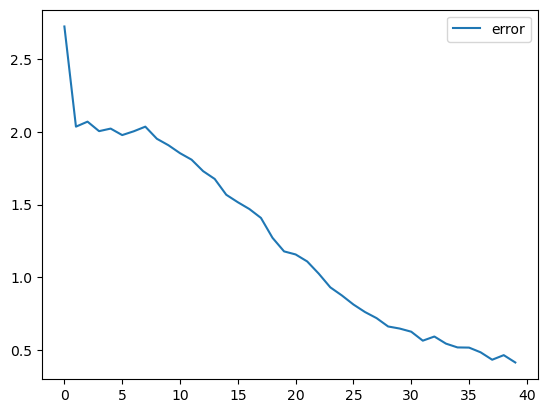

In [10]:
plt.plot(x, y, label='error')
plt.legend()
plt.show()

In [11]:
torch.save(model.state_dict(), "model_weights.pth")

Оценка модели

In [22]:
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())


Отчёт о модели

In [23]:
report = classification_report(all_labels, all_preds, target_names=test_loader.dataset.classes)
print(report)

              precision    recall  f1-score   support

        гусь       1.00      0.88      0.93        40
      индюки       0.97      0.97      0.97        40
      курица       0.95      0.90      0.92        40
       петух       0.91      0.97      0.94        40
      страус       0.91      0.97      0.94        40
        утка       0.95      0.93      0.94        40
    цыпленок       0.95      1.00      0.98        40

    accuracy                           0.95       280
   macro avg       0.95      0.95      0.95       280
weighted avg       0.95      0.95      0.95       280



In [21]:
model = CNN()
model.load_state_dict(torch.load("model_weights.pth"))

C:\Users\alexa\AppData\Local\Temp\ipykernel_3316\2954526511.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_weights.pth"))


<All keys matched successfully>